# Generate DAG

## Import packages

In [1]:
import json
from collections import defaultdict
import lucid.modelzoo.vision_models as models
import numpy as np
import networkx as nx
import operator
import matplotlib.pyplot as plt

## Get general information of InceptionV1 model

In [2]:
def get_layers(graph_nodes):
    '''
    Get all layers
    * input
        - graph_nodes: tensorflow graph nodes
    * output
        - layers: list of all layers
    '''
    layers = []
    for n in graph_nodes:
        node_name = n.name
        if node_name[-2:] == '_w':
            layer = node_name.split('_')[0]
            if layer not in layers:
                layers.append(layer)
    return layers

In [3]:
def get_channel_sizes(layer, weight_nodes):
    '''
    Get channel sizes
    * input
        - layer: the name of layer
        - weight_nodes: tensorflow nodes for all filters
    * output
        - channel_sizes: list of channel size for all pre-concatenated blocks
    '''
    
    channel_sizes = [get_shape_of_node(n)[0] for n in weight_nodes if layer in n.name and '_b' == n.name[-2:] and 'bottleneck' not in n.name]
    return channel_sizes

In [4]:
def get_shape_of_node(n):
    '''
    Get the shape of the tensorflow node
    * input
        - n: tensorflow node
    * output
        - tensor_shape: shape of n
    '''
    dims = n.attr['value'].tensor.tensor_shape.dim
    tensor_shape = [d.size for d in dims]
    return tensor_shape

## Generate DAG and save it into a file

In [5]:
def load_I_matrices(all_layers, start_layer, end_layer):
    
    # Get layers starting from the given layer to the input layer
    start_idx, end_idx = all_layers.index(start_layer), all_layers.index(end_layer)
    target_layers = all_layers[start_idx: end_idx - 1: -1]

    # Load I matrices
    Is = {}
    for layer in target_layers:
        print('loading ', layer)
        Is[layer] = load_inf_matrix(I_mat_dirpath, layer)
        for branch in [1, 2]:
            inner_layer = '{}_{}'.format(layer, branch)
            print('loading ', inner_layer)
            Is[inner_layer] = load_inf_matrix(I_mat_dirpath, inner_layer)
            
    return Is

In [6]:
def extract_class_I_matrices(Is, all_layers, start_layer, end_layer, pred_class):

    # Get layers starting from the given layer to the input layer
    start_idx, end_idx = all_layers.index(start_layer), all_layers.index(end_layer)
    target_layers = all_layers[start_idx: end_idx - 1: -1]
    
    Is_class = {}
    
    for layer in target_layers:
        print('loading ', layer)
        Is_class[layer] = Is[layer][pred_class]
        for branch in [1, 2]:
            inner_layer = '{}_{}'.format(layer, branch)
            print('loading ', inner_layer)
            Is_class[inner_layer] = Is[inner_layer][pred_class]
    
    
    return Is_class

In [7]:
def generate_save_dag(Is, pred_class, I_mat_dirpath, dag_dirpath, channels, layer_fragment_sizes, dag_k=3, start_layer='mixed5b', end_layer='mixed3a'):
    '''
    Generate DAG and save it into a file
    * input
        - pred_class: predicted class
        - all_layers: all layers
        - I_mat_dirpath: directory path of I-matrices
        - dag_dirpath: direcgtory path of dag
        - channels: starting channels in start_layer (towrards output)
        - layer_fragment_sizes: sizes of fragments in all layers
        - dag_k: the number of top impactful previous channels
        - start_layer: start layer (towards output)
        - end_layer: end layer (towards input)
    * output
        - N/A
    '''

    # Get dags
    dags = gen_impactful_dags(Is, start_layer, channels, pred_class, all_layers, layer_fragment_sizes, k=dag_k, end_layer=end_layer)

    # Save dags
    filename = dag_dirpath + 'dag-{}.json'.format(pred_class)
    with open(filename, 'w') as f:
        json.dump(dags, f, indent=2)

In [8]:
def load_inf_matrix(mat_dirpath, layer):
    '''
    Load I matrix
    * input
        - mat_dirpath: directory path of I-matrices
        - layer: layer name
    * output
        - I_mat: I-matrix of the given layer
    '''
    if mat_dirpath[-1] == '/':
        filepath = mat_dirpath + 'I_' + layer + '.json'
    else:
        filepath = mat_dirpath + '/I_' + layer + '.json'
        
    with open(filepath) as f:
        I_mat = json.load(f)
    
    return I_mat

In [9]:
def gen_impactful_dags(Is, layer, channels, pred_class, all_layers, layer_fragment_sizes, k=3, end_layer='mixed3a'):
    '''
    Generate impactful dags starting from channels in a layer to input layer
    * input
        - Is: influence matrices
        - layer: starting layer
        - channels: selected channels in the layer
        - pred_class: predicted class
        - all_layers: all layers
        - layer_fragment_sizes: sizes of fragments in all layers
        - k: the number of top impactful previous channels
        - end_layer: end layer (towards input)
    * output
        - dags: a dictionary, whose
            - key: a layer
            - val: a dictionary, which maps
                - key: a neuron in current layer
                - val: list of important neurons in the previous layer
    '''
    
    # Get layers starting from the given layer to the input layer
    start_idx, end_idx = all_layers.index(layer), all_layers.index(end_layer)
    target_layers = all_layers[start_idx: end_idx - 1: -1]
    
    # Initialize the dags
    dags = {}
    
    # Record of what channels have been added to which layers
    record = {}
    
    # Aggregate the dags across layers
    curr_channels = channels[:]
    for curr_layer in target_layers:
        dags[curr_layer] = []
        record[curr_layer] = set()
        agg_prev_channels = []
        
        for curr_channel in curr_channels:
            
            # if this channel is already in the DAG, skip
            if curr_channel in record[curr_layer]:
                pass
            
            # if this channel isn't in the DAG, do the regular computation
            else:
                prev_channels, prev_infs = get_top_prevs(Is, curr_layer, curr_channel, pred_class, layer_fragment_sizes[curr_layer], k=k)
                curr_channel_dict = {'channel': curr_channel, 'prev_channels': []}
                for prev_c, prev_inf in zip(prev_channels, prev_infs):
                    curr_channel_dict['prev_channels'].append({'prev_channel': prev_c, 'inf': prev_inf})
                dags[curr_layer].append(curr_channel_dict)
                record[curr_layer].add(curr_channel)
                agg_prev_channels += prev_channels
        curr_channels = agg_prev_channels[:]
    
    return dags

In [10]:
def get_top_prevs(I_layers, layer, channel, pred_class, layer_channels, k=3):
    '''
    Get top impactful channels in previous layer
    * input
        - I_layers: a dictionary for influence matrices for the layer
            - key: layer
            - val: influence matrix of the layer
        - layer: the name of layer
        - channel: channel in the layer
        - pred_class: the predicted class
        - layer_channels: sizes of fragments in the layer
        - k: the number of top impactful previous channels
    * output
        - top_prev_channels: top k impactful previous channels
        - top_prev_infs: influences of the top k impactful previous channels
    '''
    
    # Get influences
    infs = I_layers[layer][pred_class][channel]
    
    # Get top k previous channels
    top_prev_channels = sorted(infs, key=infs.get, reverse=True)[:k]
    top_prev_infs = [infs[c] for c in top_prev_channels]
    top_prev_channels = [int(c) for c in top_prev_channels]
        
    # Figure out which branch is connected to the channel
    branch = get_branch(layer, channel, layer_channels)
    
    # If the branch goes through inner layers
    if branch in [1, 2]:
        inner_layer = '{}_{}'.format(layer, branch)
        inf_inner = I_layers[inner_layer][pred_class]
        top_infs = defaultdict(lambda: 0)
                
        for prev_channel in top_prev_channels:
            prev_infs = inf_inner[prev_channel]
            for prev_prev_channel in prev_infs.keys():
                top_infs[prev_prev_channel] += prev_infs[prev_prev_channel]
        top_prev_prev_channels = sorted(top_infs, key=top_infs.get, reverse=True)[:k]
        top_prev_prev_infs = [top_infs[c] for c in top_prev_prev_channels]
        top_prev_prev_channels = [int(c) for c in top_prev_prev_channels]
        
        return top_prev_prev_channels, top_prev_prev_infs
        
    else:
        return top_prev_channels, top_prev_infs

In [11]:
def get_branch(layer, channel, layer_channels):
    '''
    Get branch of the channel in the layer
    * input
        - layer: the name of layer
        - channel: channel in the layer
        - layer_channels: fragment sizes of the layer
    * output
        - branch: branch of the channel
    '''
    
    channels = layer_channels[:]
    for i in range(len(channels) - 1):
        channels[i + 1] += channels[i]
        
    branch = np.searchsorted(channels, channel, side='right')
    
    return branch

## RUN - Generate DAGs for all classes

In [12]:
main_dirpath = './'
M_mat_dirpath = main_dirpath + 'data/M-matrices/'
I_mat_dirpath = main_dirpath + 'data/I-matrices/'
dag_dirpath = main_dirpath + 'data/dag/'
imgnet_dirpath = main_dirpath + 'data/'

In [13]:
start_layer = 'mixed5b'
end_layer = 'mixed3a'
dag_k = 3
num_class = 1000

In [14]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()
nodes = googlenet.graph_def.node

In [15]:
all_layers = get_layers(nodes)
mixed_layers = [layer for layer in all_layers if 'mixed' in layer]
layer_fragment_sizes = {layer: get_channel_sizes(layer, nodes) for layer in mixed_layers}

In [16]:
with open(imgnet_dirpath + 'imagenet.json') as f:
    imgnet = json.load(f)

In [17]:
Is = load_I_matrices(all_layers, start_layer, end_layer)

loading  mixed5b
loading  mixed5b_1
loading  mixed5b_2
loading  mixed5a
loading  mixed5a_1
loading  mixed5a_2
loading  mixed4e
loading  mixed4e_1
loading  mixed4e_2
loading  mixed4d
loading  mixed4d_1
loading  mixed4d_2
loading  mixed4c
loading  mixed4c_1
loading  mixed4c_2
loading  mixed4b
loading  mixed4b_1
loading  mixed4b_2
loading  mixed4a
loading  mixed4a_1
loading  mixed4a_2
loading  mixed3b
loading  mixed3b_1
loading  mixed3b_2
loading  mixed3a
loading  mixed3a_1
loading  mixed3a_2


In [81]:
pred_class = 270
Is_class = extract_class_I_matrices(Is, all_layers, start_layer, end_layer, pred_class)

loading  mixed5b
loading  mixed5b_1
loading  mixed5b_2
loading  mixed5a
loading  mixed5a_1
loading  mixed5a_2
loading  mixed4e
loading  mixed4e_1
loading  mixed4e_2
loading  mixed4d
loading  mixed4d_1
loading  mixed4d_2
loading  mixed4c
loading  mixed4c_1
loading  mixed4c_2
loading  mixed4b
loading  mixed4b_1
loading  mixed4b_2
loading  mixed4a
loading  mixed4a_1
loading  mixed4a_2
loading  mixed3b
loading  mixed3b_1
loading  mixed3b_2
loading  mixed3a
loading  mixed3a_1
loading  mixed3a_2


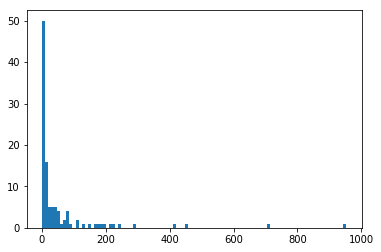

In [82]:
plt.hist(Is_class['mixed5b'][3].values(), bins=100)
plt.show()

In [83]:
G = nx.Graph()

for layer_idx, layer in enumerate(mixed_layers[::-1]):
    print(layer)
    if layer == 'mixed3a':
        pass
    else:
        
        num_of_channel_edges = []
        for i, channel in enumerate(Is_class[layer]):
            branch = get_branch(layer, i, layer_fragment_sizes[layer])
            if branch in [0,3]:
                num_of_channel_edges.append(len(channel.keys()))
                
        avg_num_of_channel_edges = int(np.mean(num_of_channel_edges))
        print(avg_num_of_channel_edges)
        
        for i, channel in enumerate(Is_class[layer]):
            src = layer + '-' + str(i)
            branch = get_branch(layer, i, layer_fragment_sizes[layer])
            if branch in [1,2]:
                many_paths = {}
                for prev_channel in Is_class[layer + '_' + str(branch)]:
                
                    for prev_prev_channel in prev_channel:
                        prev_prev_val = prev_channel[prev_prev_channel]
                        if prev_prev_channel not in many_paths:
                            many_paths[prev_prev_channel] = []
                        many_paths[prev_prev_channel].append(prev_prev_val)

#                 if i == 387:
#                     temp_weight = []
#                     for prev_prev_channel in many_paths:   
#                         weight = max(many_paths[prev_prev_channel])
#                         temp_weight.append(weight)
#                     plt.hist(temp_weight, bins=100)
#                     plt.show()
#                     asdf

                temp_weight = {}
                for prev_prev_channel in many_paths:   
                    weight = max(many_paths[prev_prev_channel])
                    temp_weight[prev_prev_channel] = weight
                
                sorted_many_paths = sorted(temp_weight.items(), key=lambda x: x[1], reverse=True)
                
                for prev_prev_channel in sorted_many_paths[0:avg_num_of_channel_edges]:
                    tgt = mixed_layers[::-1][layer_idx+1] + '-' + str(prev_prev_channel[0])
                    weight = prev_prev_channel[1]
                    G.add_edge(src, tgt, weight=weight)
            else:
                for prev_channel in channel:
                    tgt =  mixed_layers[::-1][layer_idx+1] + '-' + str(prev_channel)
                    weight = channel[prev_channel]
                    G.add_edge(src, tgt, weight=weight)

mixed5b
97
mixed5a
81
mixed4e
63
mixed4d
63
mixed4c
64
mixed4b
64
mixed4a
44
mixed3b
19
mixed3a


In [84]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 5481\nNumber of edges: 350335\nAverage degree: 127.8362'

In [85]:
personalization = {node: 1 for node in list(G.nodes)}

for layer in mixed_layers[::-1]:
    M = np.loadtxt(M_mat_dirpath + 'M-' + layer + '.csv', delimiter=',', dtype=int)
    for channel in range(M.shape[-1]):
        node = layer + '-' + str(channel)
        if node in personalization:
            personalization[layer + '-' + str(channel)] = M[pred_class][channel]    

In [86]:
pagerank = nx.pagerank(G, personalization=personalization, weight='weight', alpha=0.90)

In [87]:
pagerank_sorted = sorted(pagerank.items(), key=operator.itemgetter(1), reverse=True)

In [88]:
pageranks_per_layer_value = {}
pageranks_per_layer_node = {}

for layer in mixed_layers[::-1]:
    pageranks_per_layer_value[layer] = []
    pageranks_per_layer_node[layer] = []
    
for node in pagerank_sorted:
    layer = node[0].split('-')[0]
    pageranks_per_layer_value[layer].append(node[1])
    pageranks_per_layer_node[layer].append(node[0].split('-')[1])

In [89]:
pagerank_sorted[0:10]

[('mixed3a-190', 0.006829781165010267),
 ('mixed3b-390', 0.006096626134571075),
 ('mixed3b-399', 0.0059596130539859545),
 ('mixed5a-762', 0.0055180335878148926),
 ('mixed4e-36', 0.003153466111197727),
 ('mixed4b-418', 0.0031441902009823014),
 ('mixed4d-446', 0.0030884258129838032),
 ('mixed4e-759', 0.0030857490684067118),
 ('mixed5a-1', 0.002969688461589986),
 ('mixed4e-309', 0.00282383309777245)]

In [90]:
thresholds = {}
thresholds_vertical_line_value = {}
    
# hard threshold k = 10
# for layer in mixed_layers[::-1]:
#     thresholds[layer] = 10

# prob mass threshold 1%
prob_mass_threshold = 0.12

for layer in mixed_layers[::-1]:
    pageranks_value_sorted, pageranks_node_sorted = (list(t) for t in zip(*sorted(zip(pageranks_per_layer_value[layer], pageranks_per_layer_node[layer]), reverse=True)))
    
    top_pagerank_nodes = []
    working_pagerank_values = pageranks_value_sorted/np.sum(pageranks_value_sorted)
    prob_mass = 0
    k=0
    while prob_mass < prob_mass_threshold:
        top_pagerank_nodes.append(pageranks_node_sorted[k])
        prob_mass += working_pagerank_values[k]
        k += 1

    thresholds_vertical_line_value[layer] = pageranks_value_sorted[k]
    thresholds[layer] = k
    
# prob mass threshold 1% for all layers
# prob_mass_threshold = 0.1

# # for layer in mixed_layers[::-1]:
# #     pageranks_value_sorted, pageranks_node_sorted = (list(t) for t in zip(*sorted(zip([x[1] for x in pagerank_sorted], [x[o] for x in pagerank_sorted]), reverse=True)))
    
# top_pagerank_nodes = []
# all_pagerank_values = [x[1] for x in pagerank_sorted]
# working_pagerank_values = all_pagerank_values / np.sum(all_pagerank_values)

# prob_mass = 0
# k=0
# while prob_mass < prob_mass_threshold:
#     # top_pagerank_nodes.append(pageranks_node_sorted[k])
#     prob_mass += working_pagerank_values[k]
#     k += 1
# print(k)
# criteria = all_pagerank_values[k]
# print(criteria)
# #####

# for layer in mixed_layers[::-1]:
# #     pageranks_value_sorted, pageranks_node_sorted = (list(t) for t in zip(*sorted(zip(pageranks_per_layer_value[layer], pageranks_per_layer_node[layer]), reverse=True)))
#     print(pageranks_per_layer_value[layer][:3])
#     print(min(pageranks_per_layer_value[layer]), max(pageranks_per_layer_value[layer]))
#     idx = np.searchsorted(pageranks_per_layer_value[layer], criteria)
#     thresholds[layer] = idx
#     thresholds_vertical_line_value[layer] =idx
# # thresholds_vertical_line_value[layer] = pageranks_value_sorted[k]
# # thresholds[layer] = k

In [91]:
# all_pagerank_values[:10]

In [92]:
thresholds

{'mixed5b': 38,
 'mixed5a': 9,
 'mixed4e': 7,
 'mixed4d': 6,
 'mixed4c': 11,
 'mixed4b': 9,
 'mixed4a': 12,
 'mixed3b': 3,
 'mixed3a': 1}

mixed5b


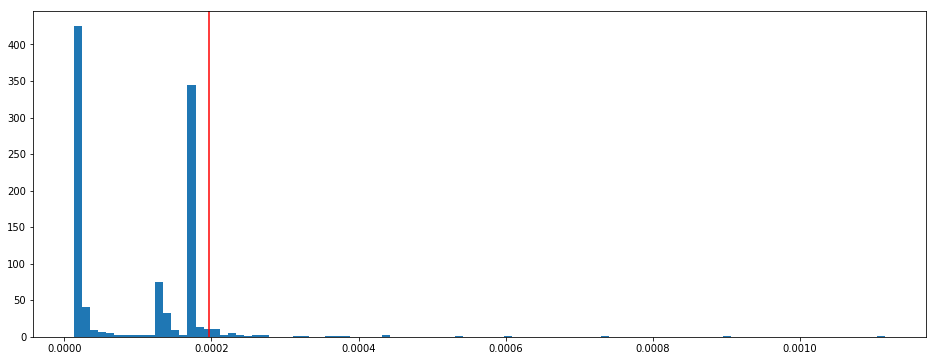

mixed5a


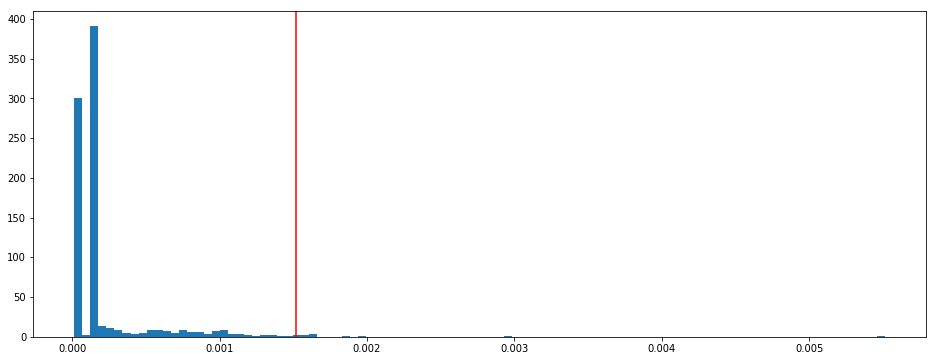

mixed4e


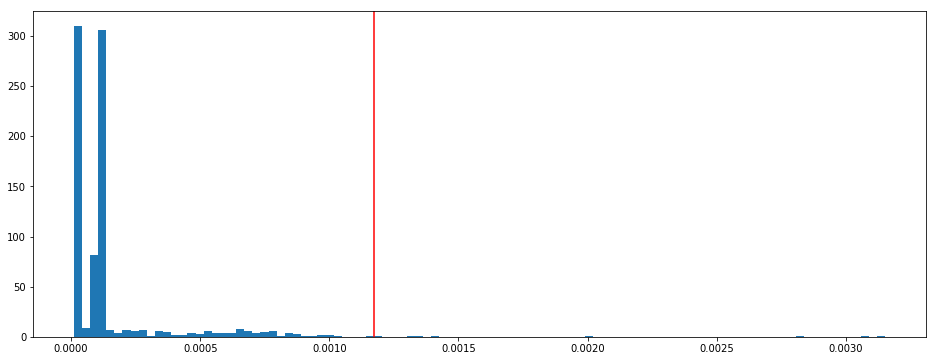

mixed4d


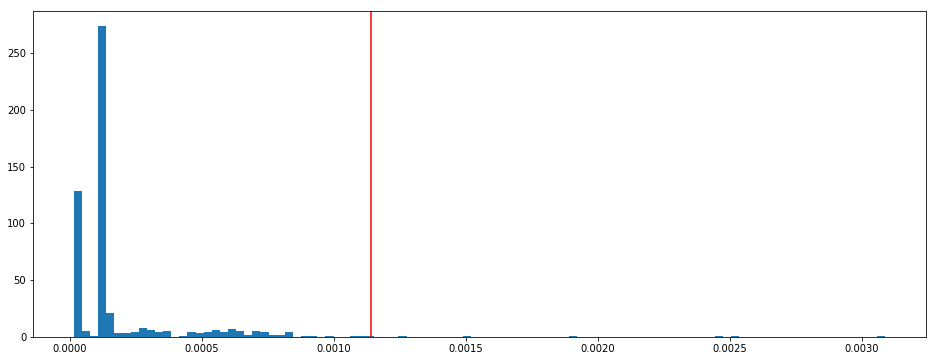

mixed4c


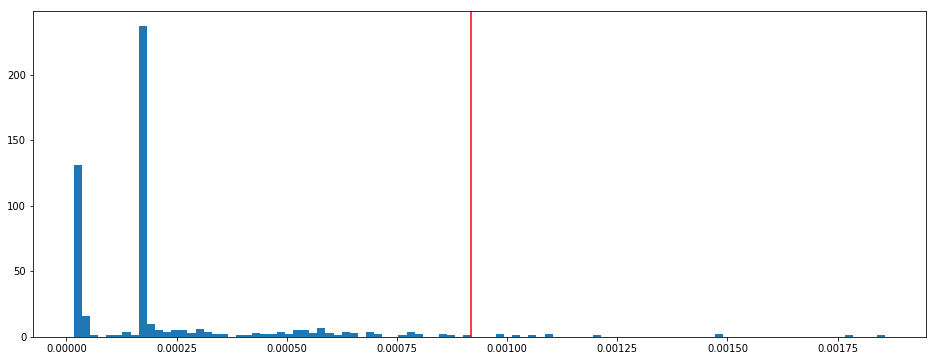

mixed4b


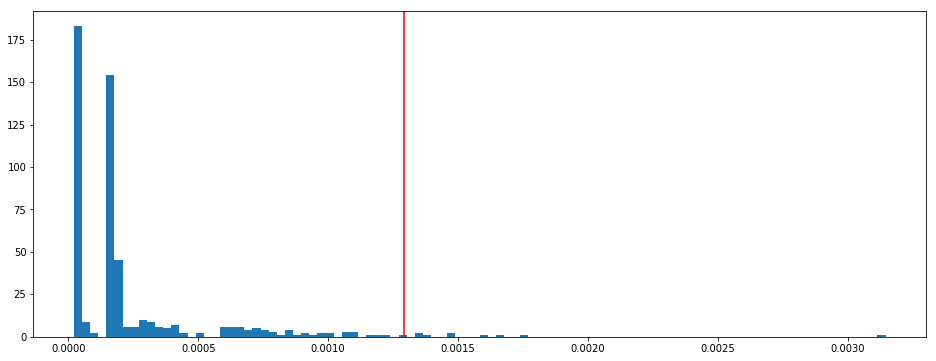

mixed4a


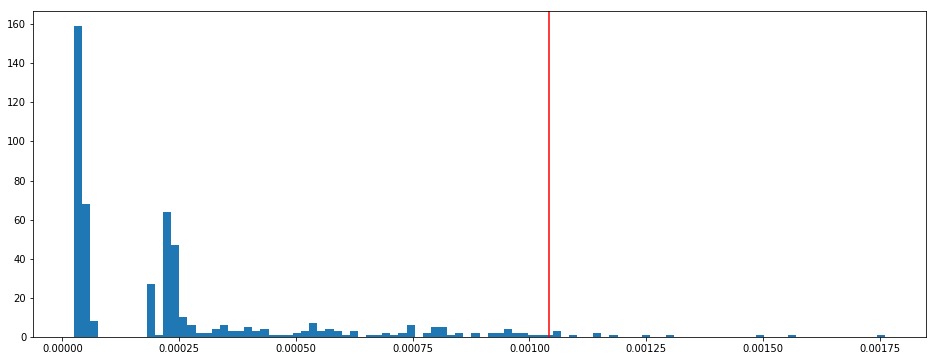

mixed3b


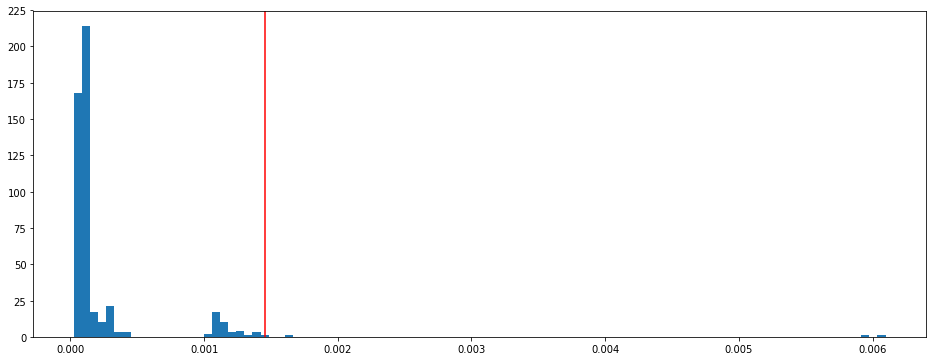

mixed3a


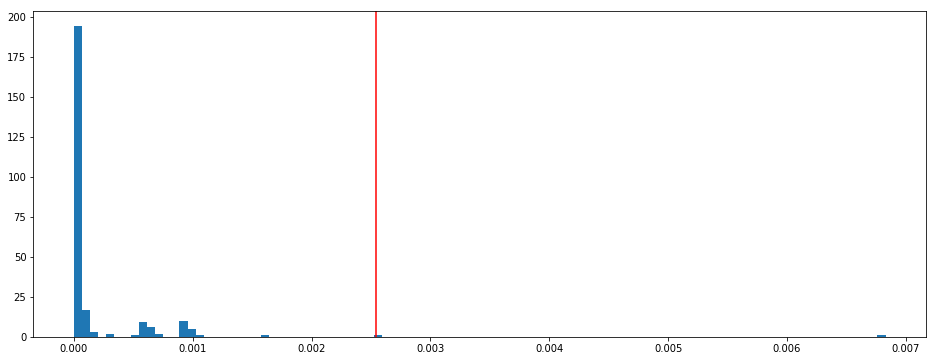

In [93]:
for layer in mixed_layers[::-1]:
    print(layer)
    plt.figure(figsize=(16,6))
    plt.hist(pageranks_per_layer_value[layer], bins=100)
    plt.axvline(x=thresholds_vertical_line_value[layer], c='red')
#     plt.xlim(0,criteria)
    plt.show()

In [94]:
channels_to_save = {}
for layer in mixed_layers[::-1]:
    channels_to_save[layer] = []

for node in pagerank_sorted:
    layer = node[0].split('-')[0]
    if len(channels_to_save[layer]) < thresholds[layer]:
        channels_to_save[layer].append({'channel': node[0], 'pagerank': node[1]})

In [95]:
channels_to_save_ids = []
for layer in mixed_layers[::-1]:
    for temp_channel in [x['channel'] for x in channels_to_save[layer]]:
        channels_to_save_ids.append(temp_channel)

In [96]:
dagG = G.subgraph(channels_to_save_ids)

In [97]:
nx.info(dagG)

'Name: \nType: Graph\nNumber of nodes: 96\nNumber of edges: 624\nAverage degree:  13.0000'

In [98]:
mixed_layers[::-1]

['mixed5b',
 'mixed5a',
 'mixed4e',
 'mixed4d',
 'mixed4c',
 'mixed4b',
 'mixed4a',
 'mixed3b',
 'mixed3a']

In [99]:
dag_pagerank = {}
edges_to_save = {} # layer, 'channel', prev_channel, weight

for layer in mixed_layers[::-1]:
    dag_pagerank[layer] = []
    edges_to_save[layer] = {}

for i, node in enumerate(dagG.nodes()):
    node_layer = node.split('-')[0]
    channel = node.split('-')[1]
    dag_pagerank[node_layer].append({
        'channel': channel,
        'prev_channels': []
    })
    
    for edge in dagG.edges(node):
        if channel == '715':
            print(edge)
        temp_idx = edge.index(node)
        if temp_idx == 0:
            tgt_node = edge[1]
        else:
            tgt_node = edge[0]
        tgt_node_layer = tgt_node.split('-')[0]
        tgt_channel = tgt_node.split('-')[1]
        
        node_layer_idx = mixed_layers[::-1].index(node_layer)
        tgt_node_layer_idx = mixed_layers[::-1].index(tgt_node_layer)
        
        if node_layer_idx < tgt_node_layer_idx:
            if node_layer not in edges_to_save:
                edges_to_save[node_layer] = {}
            if int(channel) not in edges_to_save[node_layer]:
                edges_to_save[node_layer][int(channel)] = []
            edges_to_save[node_layer][int(channel)].append({'prev_channel': int(tgt_channel), 'inf': dagG.get_edge_data(node, tgt_node)['weight']})
            
#         elif node_layer_idx >= tgt_node_layer_idx:
#             # node = prev, tgt = curr
#             # edges_to_save[tgt][tgt-channel] = [{node_channel, inf}]
            
            
            
#             if tgt_node_layer not in edges_to_save:
#                 edges_to_save[tgt_node_layer] = {}
#             if tgt_channel not in edges_to_save[tgt_node_layer]:
#                 edges_to_save[tgt_node_layer][tgt_channel] = []
                
#             edges_to_save[tgt_node_layer][tgt_channel].append({'prev_channel': channel, 'inf': dagG.get_edge_data(node, tgt_node)['weight']})
            
#         if node_layer_idx < tgt_node_layer_idx:
#             dag_pagerank[node_layer][i]['prev_channels'].append({
#                 'prev_channel': int(tgt_node),
#                 'inf': dagG.get_edge_data(node, tgt_node)['weight']
#             })
#         else:
#             dag_pagerank[tgt_layer][]['prev_channels'].append({
#                 'prev_channel': int(tgt_node),
#                 'inf': dagG.get_edge_data(node, tgt_node)['weight']
#             })


In [100]:
edges_to_save['mixed4e']

{696: [{'prev_channel': 428, 'inf': 1193},
  {'prev_channel': 431, 'inf': 1172},
  {'prev_channel': 477, 'inf': 1107},
  {'prev_channel': 403, 'inf': 1042},
  {'prev_channel': 446, 'inf': 995},
  {'prev_channel': 139, 'inf': 571}],
 608: [{'prev_channel': 428, 'inf': 1193},
  {'prev_channel': 431, 'inf': 1172},
  {'prev_channel': 477, 'inf': 1107},
  {'prev_channel': 403, 'inf': 1042},
  {'prev_channel': 446, 'inf': 995},
  {'prev_channel': 139, 'inf': 571}],
 734: [{'prev_channel': 477, 'inf': 164},
  {'prev_channel': 428, 'inf': 630},
  {'prev_channel': 139, 'inf': 189},
  {'prev_channel': 431, 'inf': 3}],
 759: [{'prev_channel': 477, 'inf': 1204},
  {'prev_channel': 431, 'inf': 263},
  {'prev_channel': 428, 'inf': 33}],
 787: [{'prev_channel': 403, 'inf': 1129}],
 309: [{'prev_channel': 139, 'inf': 1258},
  {'prev_channel': 428, 'inf': 1207},
  {'prev_channel': 477, 'inf': 1163},
  {'prev_channel': 431, 'inf': 1116},
  {'prev_channel': 446, 'inf': 1107},
  {'prev_channel': 403, 'inf

In [115]:
dag_pagerank = {}

for layer in mixed_layers[::-1]:
    dag_pagerank[layer] = []
    
for layer in mixed_layers[::-1]:
    
    M = np.loadtxt(M_mat_dirpath + 'M-' + layer + '.csv', delimiter=',', dtype=int)

    for channel in channels_to_save[layer]:
        channel_int_idx = int(channel['channel'].split('-')[1])
        if layer == 'mixed3a':
            dag_pagerank[layer].append(
            {
                'channel': channel_int_idx,
                'prev_channels': []
            })
        else:
#             print(layer, channel_int_idx)
            if channel_int_idx not in edges_to_save[layer]:
                dag_pagerank[layer].append(
                {
                    'channel': channel_int_idx,
                    'prev_channels': [],
                    'count': int(M[pred_class][channel_int_idx]),
                    'layer': layer
                })
            else:
                dag_pagerank[layer].append(
                {
                    'channel': channel_int_idx,
                    'prev_channels': edges_to_save[layer][channel_int_idx],
                    'count': int(M[pred_class][channel_int_idx]),
                    'layer': layer                    
                })

In [116]:
# edges_to_save = {}
# for layer in mixed_layers[::-1]:
#     edges_to_save[layer] = {}
    
# for i, layer in enumerate(mixed_layers[::-1]):
#     if layer == 'mixed3a':
#         pass
#     else:
#         for channel in channels_to_save[layer]:         
            
#             channel_idx = int(channel['channel'].split('-')[1])
#             edges_to_save[layer][channel_idx] = []
            
#             for prev_channel in Is_class[layer][channel_idx]:
#                 if prev_channel in [x['channel'].split('-')[1] for x in channels_to_save[mixed_layers[::-1][i+1]]]:
                    
#                     edges_to_save[layer][channel_idx].append({'prev_channel': int(prev_channel), 'inf': Is_class[layer][channel_idx][prev_channel]})

In [117]:
# edges_to_save

In [118]:
# channels_to_save

In [119]:
# dag_pagerank = {}

# for layer in mixed_layers[::-1]:
#     dag_pagerank[layer] = []
    
# for layer in mixed_layers[::-1]:
#     for channel in channels_to_save[layer]:
#         channel_int_idx = int(channel['channel'].split('-')[1])
#         if layer == 'mixed3a':
#             dag_pagerank[layer].append(
#             {
#                 'channel': channel_int_idx,
#                 'prev_channels': []
#             })
#         else:    
#             dag_pagerank[layer].append(
#             {
#                 'channel': channel_int_idx,
#                 'prev_channels': edges_to_save[layer][channel_int_idx]
#             })

In [120]:
filename = dag_dirpath + 'pagerank/' + 'dag-{}.json'.format(pred_class)
with open(filename, 'w') as f:
    json.dump(dag_pagerank, f, indent=2)

In [91]:
# for th in range(num_class):
    
#     if th % 100 == 0:
#         print(th)
    
#     pred_class = imgnet[th]['target_class']
#     prev_counter = imgnet[th]['topChannels'][start_layer]
#     channels = [prev_counter[i]['channel'] for i in range(dag_k)]    
#     generate_save_dag(Is, pred_class, I_mat_dirpath, dag_dirpath, channels, layer_fragment_sizes, 3, start_layer, end_layer)

## Test examples

In [52]:
# kit fox, mixed5b
# pred_class = 278
# channels = [765,186,270]

# white wolf, mixed4c
# pred_class = 270
# channels = [264,216]

# white wolf, mixed5b
# pred_class = 270
# channels = [821,101,116]

# fire engine, mixed5b
# pred_class = 555
# channels = [876,881,661]

# # fire engine, mixed5a
# pred_class = 555
# channels = [581,432,586]

# strawberry, mixed5a, tfr1
# pred_class = 949
# channels = [306,504,20]

# generate_save_dag(pred_class, all_layers, I_mat_dirpath, dag_dirpath, channels, layer_fragment_sizes, 3, 'mixed5b', 'mixed4b')